/home/renangas/Documents/Github Projects/rrslvq
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [99%] [4.27s]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Processed samples: 5000
Mean performance:
rrslvq - Accuracy     : 0.7692
rrslvq - Kappa        : 0.5383
rrslvq - Kappa M      : 0.5339


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

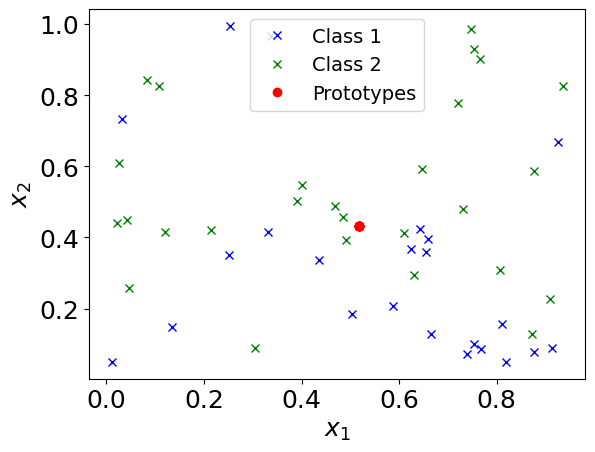

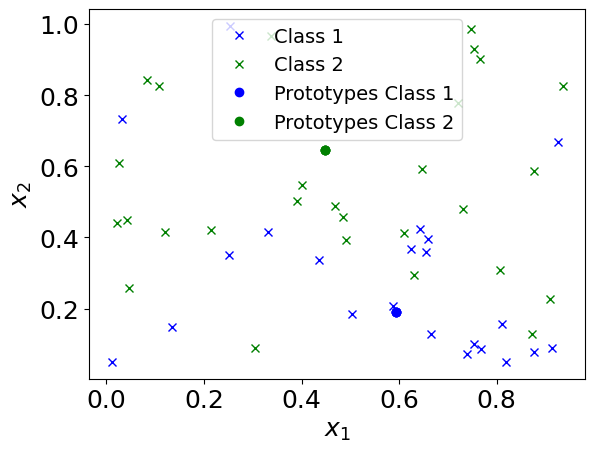

In [3]:
from __future__ import division

import math
import sys
from random import randint
from random import random as rnd

import os

import warnings

warnings.filterwarnings('ignore')

# Get the parent directory
parent_dir = os.path.dirname(os.path.realpath("/home/renangas/Documents/Github Projects/rrslvq/plots"))
print(parent_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

from rrslvq import ReactiveRobustSoftLearningVectorQuantization
from study.reoccuring_drift_stream import ReoccuringDriftStream

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import logit
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import validation
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted

from skmultiflow.drift_detection import KSWIN


from skmultiflow.data.mixed_generator import MIXEDGenerator

#Abrupt Concept Drift Generators
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.evaluation.evaluate_prequential import EvaluatePrequential
#from bix.classifiers.rrslvq import RRSLVQ






#!sr/bin/env python3
#-*- coding: utf-8 -*-
"""
Created on Fri Jun 22 09:35:11 2018

@author: moritz
"""

# TODO: add sigma for every prototype (TODO from https://github.com/MrNuggelz/sklearn-lvq)


class RRSLVQ(ClassifierMixin, BaseEstimator):
    """Robust Soft Learning Vector Quantization
    Parameters
    ----------
    prototypes_per_class : int or list of int, optional (default=1)
        Number of prototypes per class. Use list to specify different
        numbers per class.
    initial_prototypes : array-like, shape =  [n_prototypes, n_features + 1],
     optional
        Prototypes to start with. If not given initialization near the class
        means. Class label must be placed as last entry of each prototype.
    sigma : float, optional (default=0.5)
        Variance for the distribution.
    max_iter : int, optional (default=2500)
        The maximum number of iterations.
    gtol : float, optional (default=1e-5)
        Gradient norm must be less than gtol before successful termination
        of bfgs.
    display : boolean, optional (default=False)
        print information about the bfgs steps.
    random_state : int, RandomState instance or None, optional
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
    gradient_descent : string, Gradient Descent describes the used technique
        to perform the gradient descent. Possible values: 'SGD' (default),
        and 'l-bfgs-b'.
    drift_handling : string, Type of concept drift DETECTION.
        None means no concept drift detection
        If KS, use of Kolmogorov Smirnov test
        If ADWIN, use of Adaptive Sliding Window dimension wise
        IF DIST, monitoring class distances to detect outlier.


    Attributes
    ----------
    w_ : array-like, shape = [n_prototypes, n_features]
        Prototype vector, where n_prototypes in the number of prototypes and
        n_features is the number of features
    c_w_ : array-like, shape = [n_prototypes]
        Prototype classes
    classes_ : array-like, shape = [n_classes]
        Array containing labels.
    initial_fit : boolean, indicator for initial fitting. Set to false after
        first call of fit/partial fit.
    """

    def __init__(self, prototypes_per_class=1, initial_prototypes=None,
                 sigma=1.0, max_iter=2500, gtol=1e-5,
                 display=False, random_state=None,drift_handling = "KS",confidence=0.05,replace = True):
        self.sigma = sigma
        self.confidence = confidence
        self.random_state = random_state
        self.initial_prototypes = initial_prototypes
        self.prototypes_per_class = prototypes_per_class
        self.display = display
        self.max_iter = max_iter
        self.gtol = gtol
        self.initial_fit = True
        self.max_class_distances = None
        self.classes_ = []
        self.counter = 0
        self.cd_detects = []
        self.drift_handling = drift_handling
        self.drift_detected  = False
        self.replace = replace
        self.init_drift_detection = True
        self.some = []
        self.bg_data = [[],[]]
        if not isinstance(self.display, bool):
            raise ValueError("display must be a boolean")
        if not isinstance(self.max_iter, int) or self.max_iter < 1:
            raise ValueError("max_iter must be an positive integer")
        if not isinstance(self.gtol, float) or self.gtol <= 0:
            raise ValueError("gtol must be a positive float")


    def _optfun(self, variables, training_data, label_equals_prototype):
        n_data, n_dim = training_data.shape
        nb_prototypes = self.c_w_.size
        prototypes = variables.reshape(nb_prototypes, n_dim)

        out = 0

        for i in range(n_data):
            xi = training_data[i]
            y = label_equals_prototype[i]
            fs = [self._costf(xi, w) for w in prototypes]
            fs_max = max(fs)
            s1 = sum([np.math.exp(fs[i] - fs_max) for i in range(len(fs))
                      if self.c_w_[i] == y])
            s2 = sum([np.math.exp(f - fs_max) for f in fs])
            s1 += 0.0000001
            s2 += 0.0000001
            out += math.log(s1 / s2)
        return -out

    def _optimize(self, X, y, random_state):
            """Implementation of Stochastical Gradient Descent"""
            n_data, n_dim = X.shape
            nb_prototypes = self.c_w_.size
            prototypes = self.w_.reshape(nb_prototypes, n_dim)

            for i in range(n_data):
                xi = X[i]
                c_xi = y[i]
                for j in range(prototypes.shape[0]):
                    d = (xi - prototypes[j])
                    c = 0.5
                    if self.c_w_[j] == c_xi:
                        # Attract prototype to data point
                        self.w_[j] += c * (self._p(j, xi, prototypes=self.w_, y=c_xi) -
                                     self._p(j, xi, prototypes=self.w_)) * d
                    else:
                        # Distance prototype from data point
                        self.w_[j] -= c * self._p(j, xi, prototypes=self.w_) * d

    def _costf(self, x, w, **kwargs):
        d = (x - w)[np.newaxis].T
        d = d.T.dot(d)
        return -d / (2 * self.sigma)

    def _p(self, j, e, y=None, prototypes=None, **kwargs):
        if prototypes is None:
            prototypes = self.w_
        if y is None:
            fs = [self._costf(e, w, **kwargs) for w in prototypes]
        else:
            fs = [self._costf(e, prototypes[i], **kwargs) for i in
                  range(prototypes.shape[0]) if
                  self.c_w_[i] == y]

        fs_max = max(fs)
        s = sum([np.math.exp(f - fs_max) for f in fs])
        o = np.math.exp(
            self._costf(e, prototypes[j], **kwargs) - fs_max) / s
        return o

    def get_prototypes(self):
        """Returns the prototypes"""
        return self.w_


    def predict(self, x):
        """Predict class membership index for each input sample.
        This function does classification on an array of
        test vectors X.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
        Returns
        -------
        C : array, shape = (n_samples,)
            Returns predicted values.
        """
        check_is_fitted(self, ['w_', 'c_w_'])
        x = validation.check_array(x)
        if x.shape[1] != self.w_.shape[1]:
            raise ValueError("X has wrong number of features\n"
                             "found=%d\n"
                             "expected=%d" % (self.w_.shape[1], x.shape[1]))
        return np.array([self.c_w_[np.array([self._costf(xi,p) for p in self.w_]).argmax()] for xi in x])

    def posterior(self, y, x):
        """
        calculate the posterior for x:
         p(y|x)
        Parameters
        ----------

        y: class
            label
        x: array-like, shape = [n_features]
            sample
        Returns
        -------
        posterior
        :return: posterior
        """
        check_is_fitted(self, ['w_', 'c_w_'])
        x = validation.column_or_1d(x)
        if y not in self.classes_:
            raise ValueError('y must be one of the labels\n'
                             'y=%s\n'
                             'labels=%s' % (y, self.classes_))
        s1 = sum([self._costf(x, self.w_[i]) for i in
                  range(self.w_.shape[0]) if
                  self.c_w_[i] == y])
        s2 = sum([self._costf(x, w) for w in self.w_])
        return s1 / s2

    def get_info(self):
        return 'RSLVQ'

    def predict_proba(self, X):
        """ predict_proba

        Predicts the probability of each sample belonging to each one of the
        known target_values.

        Parameters
        ----------
        X: Numpy.ndarray of shape (n_samples, n_features)
            A matrix of the samples we want to predict.

        Returns
        -------
        numpy.ndarray
            An array of shape (n_samples, n_features), in which each outer entry is
            associated with the X entry of the same index. And where the list in
            index [i] contains len(self.target_values) elements, each of which represents
            the probability that the i-th sample of X belongs to a certain label.

        """
        return 'Not implemented'

    def reset(self):
        self.__init__()

    def _validate_train_parms(self, train_set, train_lab, classes=None):
        random_state = validation.check_random_state(self.random_state)
        train_set, train_lab = validation.check_X_y(train_set, train_lab)

        if(self.initial_fit):
            if(classes):
                self.classes_ = np.asarray(classes)
                self.protos_initialized = np.zeros(self.classes_.size)
            else:
                self.classes_ = unique_labels(train_lab)
                self.protos_initialized = np.zeros(self.classes_.size)

        nb_classes = len(self.classes_)
        nb_samples, nb_features = train_set.shape  # nb_samples unused

        # set prototypes per class
        if isinstance(self.prototypes_per_class, int):
            if self.prototypes_per_class < 0 or not isinstance(
                    self.prototypes_per_class, int):
                raise ValueError("prototypes_per_class must be a positive int")
            # nb_ppc = number of protos per class
            nb_ppc = np.ones([nb_classes],
                             dtype='int') * self.prototypes_per_class
        else:
            nb_ppc = validation.column_or_1d(
                validation.check_array(self.prototypes_per_class,
                                       ensure_2d=False, dtype='int'))
            if nb_ppc.min() <= 0:
                raise ValueError(
                    "values in prototypes_per_class must be positive")
            if nb_ppc.size != nb_classes:
                raise ValueError(
                    "length of prototypes per class"
                    " does not fit the number of classes"
                    "classes=%d"
                    "length=%d" % (nb_classes, nb_ppc.size))

        # initialize prototypes
        if self.initial_prototypes is None:
            #self.w_ = np.repeat(np.array([self.geometric_median(train_set[train_lab == l],"minimize") for l in self.classes_]),nb_ppc,axis=0)
            #self.c_w_ = np.repeat(self.classes_,nb_ppc)
            if self.initial_fit:
                self.w_ = np.empty([np.sum(nb_ppc), nb_features], dtype=np.double)
                self.c_w_ = np.empty([nb_ppc.sum()], dtype=self.classes_.dtype)
            pos = 0
            for actClass in range(len(self.classes_)):
                nb_prot = nb_ppc[actClass] # nb_ppc: prototypes per class
                if(self.protos_initialized[actClass] == 0 and actClass in unique_labels(train_lab)):
                    mean = np.mean(
                        train_set[train_lab == self.classes_[actClass], :], 0)
                    self.w_[pos:pos + nb_prot] = mean + (
                            random_state.rand(nb_prot, nb_features) * 2 - 1)
                    if math.isnan(self.w_[pos, 0]):
                        print('null: ', actClass)
                        self.protos_initialized[actClass] = 0
                    else:
                        self.protos_initialized[actClass] = 1
    #
                    self.c_w_[pos:pos + nb_prot] = self.classes_[actClass]
                pos += nb_prot

        else:
            x = validation.check_array(self.initial_prototypes)
            self.w_ = x[:, :-1]
            self.c_w_ = x[:, -1]
            if self.w_.shape != (np.sum(nb_ppc), nb_features):
                raise ValueError("the initial prototypes have wrong shape\n"
                                 "found=(%d,%d)\n"
                                 "expected=(%d,%d)" % (
                                     self.w_.shape[0], self.w_.shape[1],
                                     nb_ppc.sum(), nb_features))
            if set(self.c_w_) != set(self.classes_):
                raise ValueError(
                    "prototype labels and test data classes do not match\n"
                    "classes={}\n"
                    "prototype labels={}\n".format(self.classes_, self.c_w_))
        if self.initial_fit:
            self.initial_fit = False

        return train_set, train_lab, random_state

    def fit(self, X, y, classes=None):
        """Fit the LVQ model to the given training data and parameters using
        l-bfgs-b.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
          Training vector, where n_samples in the number of samples and
          n_features is the number of features.
        y : array, shape = [n_samples]
          Target values (integers in classification, real numbers in
          regression)
        Returns
        --------
        self
        """
        X, y, random_state = self._validate_train_parms(X, y, classes=classes)
        if len(np.unique(y)) == 1:
            raise ValueError("fitting " + type(
                self).__name__ + " with only one class is not possible")
        self._optimize(X, y, random_state)
        return self

    def partial_fit(self, X, y, classes=None):
        """Fit the LVQ model to the given training data and parameters using
        l-bfgs-b.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
          Training vector, where n_samples in the number of samples and
          n_features is the number of features.
        y : array, shape = [n_samples]
          Target values (integers in classification, real numbers in
          regression)
        Returns
        --------
        self
        """

        if unique_labels(y) in self.classes_ or self.initial_fit:
            X, y, random_state = self._validate_train_parms(
                X, y, classes=classes)
        else:
            raise ValueError('Class {} was not learned - please declare all \
                             classes in first call of fit/partial_fit'.format(y))

        self.counter = self.counter + 1
        if self.drift_handling is not None and self.concept_drift_detection(X,y):
            self.cd_handling(X,y)
            if self.counter > 30:
                self.save_data(X,y,random_state)
            self.cd_detects.append(self.counter)
            print(self.w_.shape)



        self._optimize(X, y, random_state)
        return self

    def save_data(self,X,y,random_state):
        pd.DataFrame(self.w_).to_csv("Prototypes.csv")
        pd.DataFrame(self.c_w_).to_csv("Prototype_Labels.csv")
        pd.DataFrame(X).to_csv("Data.csv")
        pd.DataFrame(y).to_csv("Labels.csv")
        self._optimize(X, y, random_state)
        pd.DataFrame(self.w_).to_csv("Prototypes1.csv")
        pd.DataFrame(self.c_w_).to_csv("Prototype_Labels1.csv")

    def calcDistances(self,pts,x):
        dists = []
        for p in pts:
            for elem in x:
                dists.append(np.linalg.norm(p-elem))
        return np.max(dists)

    def concept_drift_detection(self,X,Y):
        if self.init_drift_detection:
            if self.drift_handling == "KS":
                self.cdd = [KSWIN(alpha=self.confidence) for elem in X.T]
            if self.drift_handling == "DIST":
                self.cdd = [KSWIN(self.confidence) for c in self.classes_]
        self.init_drift_detection = False
        self.drift_detected = False

        if self.drift_handling == "DIST":
            try:
                class_prototypes = [self.w_[self.c_w_==elem] for elem in self.classes_]
                new_distances = dict([(c,self.calcDistances(pts,X[Y==c])) for c,pts in zip(self.classes_,class_prototypes)])
                for (c,d_new), detector in zip(new_distances.items(), self.cdd):
                    detector.add_element(d_new)
                    if detector.detected_change():
                         self.drift_detected = True
            except Exception as e:
                print("Warning: Current Batch does not contain all labels!")
                #ValueError('zero-size array to reduction operation maximum which has no identity',)
                # In this batch not every label is present
        else:
            if not self.init_drift_detection:
                for elem,detector in zip(X.T,self.cdd):
                    for e in elem:
                        detector.add_element(e)
                        if detector.detected_change():
                            self.drift_detected = True


        return self.drift_detected

    def cd_handling(self,X,Y):
        if self.replace:
            labels = np.concatenate([np.repeat(l,self.prototypes_per_class) for l in self.classes_])
            #new_prototypes = np.array([np.mean(np.array([detector.window[-30:] for detector in self.cdd]),axis=1) for l in labels])
            new_prototypes = np.array([self.geometric_median(np.array([detector.window[-30:] for detector in self.cdd]).T) for l in labels])

            self.w_ = new_prototypes
            self.c_w_ = labels
            if type(self.initial_prototypes) == np.ndarray:
                self.initial_prototypes = np.append(new_prototypes,labels[:,None],axis=1)
        else:
            labels = self.classes_
            new_prototypes = np.array([self.geometric_median(X[Y == l],"minimize") for l in labels])
            self.w_ = np.append(self.w_,new_prototypes,axis=0)
            self.c_w_ = np.append(self.c_w_,labels,axis=0)
            self.prototypes_per_class = self.prototypes_per_class + 1
            if type(self.initial_prototypes) == np.ndarray:
                self.initial_prototypes = np.append(self.initial_prototypes,np.append(new_prototypes,labels[:,None],axis=1),axis=0)

    def geometric_median(self,points):
        """
    Calculates the geometric median of an array of points.

    method specifies which algorithm to use:
        * 'auto' -- uses a heuristic to pick an algorithm
        * 'minimize' -- scipy.optimize the sum of distances
        * 'weiszfeld' -- Weiszfeld's algorithm
    given by https://github.com/mrwojo/geometric_median/blob/master/geometric_median/geometric_median.py
    """

        points = np.asarray(points)

        if len(points.shape) == 1:
            # geometric_median((0, 0)) has too much potential for error.
            # Did the user intend a single 2D point or two scalars?
            # Use np.median if you meant the latter.
            raise ValueError("Expected 2D array")

        # objective function
        def aggregate_distance(x):
            return cdist([x], points).sum()

        # initial guess: centroid
        centroid = points.mean(axis=0)

        optimize_result = minimize(aggregate_distance, centroid, method='COBYLA')

        return optimize_result.x

if __name__ == "__main__":

    s1 = MIXEDGenerator(classification_function = 1, random_state= 112, balance_classes = False)
    s2 = MIXEDGenerator(classification_function = 0, random_state= 112, balance_classes = False)

    """1. Create stream"""
    stream = ReoccuringDriftStream(stream=s1,
                            drift_stream=s2,
                            random_state=None,
                            alpha=90.0, # angle of change grade 0 - 90
                            position=2000,
                            width=1)
    stream.prepare_for_use()
    rrslvq = ReactiveRobustSoftLearningVectorQuantization(prototypes_per_class=4,sigma=12,confidence=0.1)

    model_names = ["rrslvq"]

    evaluator = EvaluatePrequential(show_plot=False,max_samples=5000,
    restart_stream=True,batch_size=50,metrics=['kappa', 'kappa_m', 'accuracy'])

    evaluator.evaluate(stream=stream, model=rrslvq,model_names=model_names)

    p1 = pd.read_csv("Prototypes.csv",index_col=0).values
    p1l = pd.read_csv("Prototype_Labels.csv",index_col=0).values[:,0]
    p2 = pd.read_csv("Prototypes1.csv",index_col=0).values
    p2l = pd.read_csv("Prototype_Labels1.csv",index_col=0).values[:,0]

    X = pd.read_csv("Data.csv",index_col=0).values
    y = pd.read_csv("Labels.csv",index_col=0).values[:,0]

    idx1 =  [-2]
    idx2 =  [-1]


i = 1
SIZE = 18
SMALL = 14
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL)  # legend fontsize
plt.rc('figure', titlesize=SIZE)
for x,z in zip(idx1,idx2):
    plt.figure(i)
    i = i +1
    fig, ax = plt.subplots()
    # ax.set_title('Insert as Mean')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    red, = plt.plot(p1[:,x],p1[:,z],'ro')
    brown, = plt.plot(X[y==0][:,x],X[y==0][:,z],'bx')
    green,= plt.plot(X[y==1][:,x],X[y==1][:,z],'gx')
    plt.legend([brown, green,red], ["Class 1", "Class 2","Prototypes"])
    # ax.set_title('Insert Step')
    fig.savefig("insert.eps",dpi=1000, format='eps',bbox_inches='tight')

    plt.figure(i)
    i = i +1
    fig, ax = plt.subplots()
    # ax.set_title('Optimization step')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    brown, = plt.plot(X[y==0][:,x],X[y==0][:,z],'bx')
    green, plt.plot(X[y==1][:,x],X[y==1][:,z],'gx')
    brown_prot, = plt.plot(p2[p2l==0][:,x],p2[p2l==0][:,z],'bo')
    green_prot, = plt.plot(p2[p2l==1][:,x],p2[p2l==1][:,z],'go')
    plt.legend([brown, green,brown_prot,green_prot], ["Class 1", "Class 2","Prototypes Class 1","Prototypes Class 2"])
    fig.savefig("optimization.eps",dpi=1000, format='eps',bbox_inches='tight')
plt.show()
